**Due date is Wednesday, March 10, 2021, 23:59 PST**

**ONLY write into the existing cells, and do NOT delete or add any cells.**

# ELEC 400M / EECE 571M Assignment 2: Neural networks
(This assignment is a modified version of an assignment used in ECE 421 at the University of Toronto and kindly made available to us by the instructor.)

In this assignment, you will implement a neural network model for multi-class classification. The purpose is to demonstrate an understanding of the basic elements including training of neural network models. Hence, your implementation will be from scratch only using functions from the NumPy library.

The neural network you will be implementing has the following structure:
* 1 input layer, 1 hidden layer with ReLU activation and 1 output layer with Softmax function
* The loss function is the Cross Entropy Loss.
* Training will be done using Gradient Descent with Momentum. 

## Data Set
We again consider the dataset of images of letters in different fonts contained in file notMNIST.npz (which btw is from http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html). This time we consider 10 letters ("A" to "J"), which are all the letters contained in this data set, and we want to classfiy the images according to the letter they display. The figure below shows 30 randomly selected image samples for the letters.

<img src="sample_images_2.png" width="400">

You will apply the function `loadData` given below to load the data set, which includes 18720 images and their labels, which we also refer to as **targets**. This script organizes the data set into training, validation and test sets. 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def loadData():
    with np.load('notMNIST.npz') as data:
        Data, Target = data['images'], data['labels']
        np.random.seed(521)
        randIndx = np.arange(len(Data))
        np.random.shuffle(randIndx)
        Data = Data[randIndx]/255.0
        Target = Target[randIndx]
        trainData, trainTarget = Data[:15000], Target[:15000]
        validData, validTarget = Data[15000:16000], Target[15000:16000]
        testData, testTarget = Data[16000:], Target[16000:]
       
    return trainData, validData, testData, trainTarget, validTarget, testTarget

## Data preprocessing [5 points]

Input data: The classification should be based on the $d=28\times 28=784$ intensity values in an image (as for Assignment 1).

Output data: Since you will be performing multi-class classification, the labels will be converted into a one-hot encoding format. 

Please first briefly explain the meaning of one-hot encoding and why it is used (instead of keeping the numerical label values provided by the data set). State an example for a one-hot encoded label for the data set considered in this assignment. Use the text cell below for this. 

After that, implement a function that one-hot encodes the labels (or targets) for the training, validation and test sets

In general, most ML algorithms can't operate on label data directly. They require all input/output variables to be numeric. To convert categorical data to numeric data, we have to go through two steps: Integer Encoding, and One-hot Encoding. In integer encoding, labels are simply mapped to integer values; such as letters A = 0, B = 1, C = 2, etc. The integer values have a natural ordered relationship between each other and ML algorithms may be able to understand this relationship. However for categorical variables where no ordinal relationship exists, integer coding is not enough, it can result in poor performance. We must use one-hot encoding, where each integer is represented as a binary vector that is all zeroes except the index value, which will be a 1.  Such as: 
A = [1,0,0,0,0,0,0,0,0,0]
B = [0,1,0,0,0,0,0,0,0,0]

In [3]:
def convertOneHot(trainTarget, validTarget, testTarget):
    # YOUR CODE HERE
    num_classes = 10
    train_one_hot = np.zeros(shape=(trainTarget.shape[0], num_classes))
    valid_one_hot = np.zeros(shape=(validTarget.shape[0], num_classes)) if validTarget is not None else None
    test_one_hot = np.zeros(shape=(testTarget.shape[0], num_classes)) if testTarget is not None else None

    for i, x in enumerate(trainTarget):
        train_one_hot[i, x] = 1.0

    if validTarget is not None:
        for i, x in enumerate(validTarget):
            valid_one_hot[i, x] = 1.0
    
    if validTarget is not None:
        for i, x in enumerate(testTarget):
            test_one_hot[i, x] = 1.0
        
    return train_one_hot, valid_one_hot, test_one_hot

## Structure of the network [2 points]

Sketch the structure of the network to classify the letters from the data set. Identify the dimensions of the network layers, include the activation functions, and do not forget the bias nodes. (You may sketch this by hand and upload a photo of your sketch.)

Note: Uploaded all the pictures including this one and the graphs to the assignment folder, it should be displayed properly, but if not, please reach out to me, thanks!

<img src="networkStructure.jpeg" width="500">

## Helper functions [6 points]
To give the implementation of the network some structure, you will first implement five helper functions. 

Use Numpy arrays for your implementations, and organize data in vectors and matrices as appropriate for compact programming (i.e., avoid `for` loops).

1. `relu`: This function will accept one argument and return the ReLU activation: 
    $$\mathrm{ReLU}(x)=\max(0,x).$$
    
2. `softmax`: This function will accept one argument and return the softmax activations:
    $$ [\sigma(\mathbf{z})]_j = \frac{\mathrm{e}^{z_j}}{\sum\limits_{k=1}^K\mathrm{e}^{z_k}},$$ $j=1,2,\ldots, K$,  for $K$ classes.
    
You may want to program the `relu` and the `softmax` functions that you call them once for all $N$ samples to be processed.    

3. `computeLayer`: This function will accept two arguments, the input vectors $\mathbf{x}^{(\ell-1)}_n$ and the weight matrix $\mathbf{W}^{(\ell)}$ for a layer $\ell$, and return the vectors $\mathbf{s}_n^{(\ell)}=(\mathbf{W}^{(\ell)})^T\mathbf{x}_n^{(\ell)}$, $n=1,2,\ldots,N$, i.e., the inputs to the activation function of that layer (the notation for variables from the textbook is used). Don't forget to account for the bias term (which can be included in augmented vectors $\mathbf{x}^{(\ell)}_n$ as in the textbook).

4. `CE`: This function will accept two arguments, the one-hot encoded labels $\mathbf{y}_n$ and the inputs $\mathbf{s}_n$ to the softmax function, $n=1,2,\ldots, N$. It will return the average cross entropy loss
$$\mathrm{E}_{\mathrm{in}}=-\frac{1}{N}\sum\limits_{n=1}^N\sum\limits_{k=1}^Ky_{n,k}\log([\sigma(\mathbf{s}_n)]_k)$$

5. `gradCE`: This function will accept two arguments, the one-hot encoded labels $\mathbf{y}_n$ and the inputs $\mathbf{s}_n$ to the softmax function, $n=1,2,\ldots, N$. It will return the gradients of the cross entropy loss for each data sample with respect to $\mathbf{s}_n$, i.e., it returns the sensivity vectors for the output layer as introduced in the textbook:
$$\boldsymbol{\mathbf{\delta}}^{(L)}_n=\frac{\partial e_n}{\partial \mathbf{s}_n^{(L)}},\quad n=1,2,\ldots,N.$$. 

First state the analytical expression for the gradient used in `gradCE` and then implement the five helper functions.

$$\boldsymbol{\mathbf{\delta}}^{(l)}_n= -\frac{1}{N}\sum\limits_{n=1}^N\sum\limits_{k=1}^K \frac{y_{n,k}{(1-e^{s_{n}})}}{e^{s_{n}}}  $$


In [4]:
def relu(x):
    # YOUR CODE HERE
    return np.maximum(x, 0)

In [5]:
def softmax(x):    
    # YOUR CODE HERE
    # prevent overflow
    s = np.max(x, axis=1)
    s = s[:, np.newaxis]
    e_x = np.exp(x - s)
    div = np.sum(e_x, axis=1)
    div = div[:, np.newaxis]
    return e_x / div

In [6]:
def computeLayer(x,W):
    # YOUR CODE HERE
    return W.T @ x

In [7]:
def CE(target, softmaxinput):
    # YOUR CODE HERE
    probs = softmax(softmaxinput)
    return -np.mean((target * np.log(probs)).sum(1))

In [8]:
def gradCE(target, softmaxinput):
    # YOUR CODE HERE
    grad = softmax(softmaxinput) - target
    return grad

## Backpropagation [2 points]

The training of the network will be done via backpropagation. First derive the following gradients:
1. $\frac{\partial E_{\mathrm{in}}}{\partial \mathbf{W}^{\mathrm{o}}}$, where $\mathbf{W}^{\mathrm{o}}$ is the weight matrix of the output layer.

2. $\frac{\partial E_{\mathrm{in}}}{\partial \mathbf{W}^{\mathrm{h}}}$, where $\mathbf{W}^{\mathrm{h}}$ is the weight matrix of the hidden layer.

Write the results using the steps and notation used in the textbook.

$$\frac{\partial E_{\mathrm{in}}}{\partial \mathbf{W}^{\mathrm{o}}} = \underline{x}^{(h-1)}\cdot[\delta^{(h)}]^T$$

$$\frac{\partial E_{\mathrm{in}}}{\partial \mathbf{W}^{\mathrm{h}}} =  \theta^\prime (\underline{s}^h)^T\bigotimes [(W_o \cdot (\delta^L)^T] $$

## Network training [8 points]

Implement a function to train the network. The function uses the helper functions from above. The optimization technique for backpropagation will be Gradient Descent with Momentum (i.e., we consider batch gradient descent, using all data samples for computing the gradient):
$$\mathbf{V}(t)=\alpha \mathbf{V}(t-1)-\eta\frac{\partial E_{\mathrm{in}}}{\partial \mathbf{W}(t)}$$
and 
$$\mathbf{W}(t+1)=\mathbf{W}(t)+\mathbf{V}(t),$$
where $\eta$ is the learning rate and $\alpha$ is the momentum hyperparameter.

The training function accepts the following inputs:  training data (features), training labels (targets), weight matrix of the hidden layer, weight matrix of the output layer, number of iterations (which is equal to the number of epochs as we consider batch gradient descent), parameters $\eta$ and $\alpha$, validation data, validation labels, test data, test labels. The validation and test inputs are initialized to "None" and need not be passed on. You will also need to initialize the velocity matrices $\mathbf{V}$ for both hidden layer and output layer weights to small values, e.g. $10^{-5}%$.

The function outputs the updated weight matrices after training, the CE loss and the classification accuracy for the training data as a function of the iteration, and if validation and test inputs were provided, then it also outputs the classification accuracies for the validation and test data as functions of the iteration,.

In [9]:
# YOUR CODE HERE
def accuracy(target, softmaxinput):
    probs = softmax(softmaxinput)
    return np.sum(np.argmax(target, axis=1) == np.argmax(probs, axis=1)) / target.shape[0]

def train(X_train, y_train, hidden_weights, output_weights, iterations, alpha, eta, X_val=None, 
          y_val=None, X_test=None, y_test=None):
    hidden_velocity = np.ones_like(hidden_weights) * 1e-5
    output_velocity = np.ones_like(output_weights) * 1e-5
    
    y_train_hot, y_val_hot, y_test_hot = convertOneHot(y_train, y_val, y_test)
    X_train = np.append(X_train, np.ones(shape=(X_train.shape[0], 1)), axis=1)
    
    if X_val is not None:
        X_val = np.append(X_val, np.ones(shape=(X_val.shape[0], 1)), axis=1)
    
    if X_test is not None:
        X_test = np.append(X_test, np.ones(shape=(X_test.shape[0], 1)), axis=1)
    
    train_loss = []
    train_acc = []
    val_acc = [] if y_val is not None else None
    test_acc = [] if y_test is not None else None
    
    for i in range(iterations):
        hidden_outs = relu(X_train @ hidden_weights)
        hidden_outs = np.append(hidden_outs, np.ones(shape=(hidden_outs.shape[0], 1)), axis=1)
        last_layers = hidden_outs @ output_weights
        loss = CE(y_train_hot, last_layers)

        gradfinal = gradCE(y_train_hot, last_layers)
        grad_output_weights = hidden_outs.T @ gradfinal
        
        relu_der = ((X_train @ hidden_weights) > 0).astype(int)
        grad_first_layer = relu_der * (gradfinal @ output_weights.T)[:, :-1]
        grad_hidden_weights = X_train.T @ grad_first_layer

        
        hidden_velocity = (alpha * hidden_velocity - eta * grad_hidden_weights)
        hidden_weights += hidden_velocity

        output_velocity = (alpha * output_velocity - eta * grad_output_weights)
        output_weights += output_velocity
        
        train_loss.append(loss)
        train_acc.append(accuracy(y_train_hot, last_layers))
        
        if val_acc is not None:
            hidden_outs = relu(X_val @ hidden_weights)
            hidden_outs = np.append(hidden_outs, np.ones(shape=(hidden_outs.shape[0], 1)), axis=1)
            last_layers = hidden_outs @ output_weights
            val_acc.append(accuracy(y_val_hot, last_layers))
            
        if test_acc is not None:
            hidden_outs = relu(X_test @ hidden_weights)
            hidden_outs = np.append(hidden_outs, np.ones(shape=(hidden_outs.shape[0], 1)), axis=1)
            last_layers = hidden_outs @ output_weights
            test_acc.append(accuracy(y_test_hot, last_layers))
            
        Verbose = True
        if Verbose:
            print('Iteration {}: train loss = {}, train accuracy = {}'.format(i+1, loss, train_acc[-1]))
            if val_acc is not None:
                print('Iteration {}: val accuracy = {}'.format(i+1, val_acc[-1]))
    
    return hidden_weights, output_weights, train_loss, train_acc, val_acc, test_acc

## Network test [4 points]

Write a script that constructs the neural network.

Initialize your weight matrices by drawing the elements i.i.d. at random from a zero-mean Gaussian distribution with variance equal to $$\sigma_w^2=\frac{2}{\mbox{# of input nodes + # of output nodes}}$$ (Xavier normalization http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf) 

Build a network with 1000 hidden units and train it for 200 iterations ($=$epochs) using $\alpha=0.9$ and $\eta=10^{-5}$. Plot the training, validation and testing accuracy curves (i.e., accuracy as a function of iteration). State the final training, validation and testing accuracies after training. Show the plot and state the final accuracies in the next text cell.

Iteration 1: train loss = 2.5669137817827163, train accuracy = 0.09626666666666667
Iteration 1: val accuracy = 0.21
Iteration 2: train loss = 2.377739978454189, train accuracy = 0.21093333333333333
Iteration 2: val accuracy = 0.5
Iteration 3: train loss = 2.0151344785119494, train accuracy = 0.5178
Iteration 3: val accuracy = 0.575
Iteration 4: train loss = 1.4896153806117223, train accuracy = 0.5808666666666666
Iteration 4: val accuracy = 0.673
Iteration 5: train loss = 1.0607990172655213, train accuracy = 0.6724666666666667
Iteration 5: val accuracy = 0.733
Iteration 6: train loss = 0.9223224604361152, train accuracy = 0.7132666666666667
Iteration 6: val accuracy = 0.812
Iteration 7: train loss = 0.7015449224874232, train accuracy = 0.8167333333333333
Iteration 7: val accuracy = 0.761
Iteration 8: train loss = 0.7366104277201269, train accuracy = 0.7644
Iteration 8: val accuracy = 0.782
Iteration 9: train loss = 0.6822151453901429, train accuracy = 0.7784666666666666
Iteration 9: val

Iteration 74: train loss = 0.22903259115154628, train accuracy = 0.9339333333333333
Iteration 74: val accuracy = 0.919
Iteration 75: train loss = 0.22738357900194117, train accuracy = 0.9337333333333333
Iteration 75: val accuracy = 0.919
Iteration 76: train loss = 0.22574690067198086, train accuracy = 0.9341333333333334
Iteration 76: val accuracy = 0.919
Iteration 77: train loss = 0.22413868614871915, train accuracy = 0.9347333333333333
Iteration 77: val accuracy = 0.919
Iteration 78: train loss = 0.22257131864735807, train accuracy = 0.9352666666666667
Iteration 78: val accuracy = 0.919
Iteration 79: train loss = 0.22099221560763027, train accuracy = 0.936
Iteration 79: val accuracy = 0.92
Iteration 80: train loss = 0.21942246705528226, train accuracy = 0.9366
Iteration 80: val accuracy = 0.92
Iteration 81: train loss = 0.21788462100687403, train accuracy = 0.9369333333333333
Iteration 81: val accuracy = 0.92
Iteration 82: train loss = 0.2163617080674702, train accuracy = 0.9372666666

Iteration 145: train loss = 0.14186886625912684, train accuracy = 0.9637333333333333
Iteration 145: val accuracy = 0.93
Iteration 146: train loss = 0.14093672088586, train accuracy = 0.9641333333333333
Iteration 146: val accuracy = 0.93
Iteration 147: train loss = 0.14001189689625698, train accuracy = 0.9645333333333334
Iteration 147: val accuracy = 0.93
Iteration 148: train loss = 0.1390923846673726, train accuracy = 0.9647333333333333
Iteration 148: val accuracy = 0.93
Iteration 149: train loss = 0.13817875610583366, train accuracy = 0.9648666666666667
Iteration 149: val accuracy = 0.93
Iteration 150: train loss = 0.13727244048326878, train accuracy = 0.9649333333333333
Iteration 150: val accuracy = 0.93
Iteration 151: train loss = 0.13637198834150066, train accuracy = 0.9654666666666667
Iteration 151: val accuracy = 0.93
Iteration 152: train loss = 0.13547688559914492, train accuracy = 0.9658666666666667
Iteration 152: val accuracy = 0.93
Iteration 153: train loss = 0.13458747084494

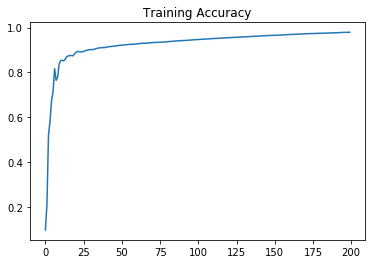

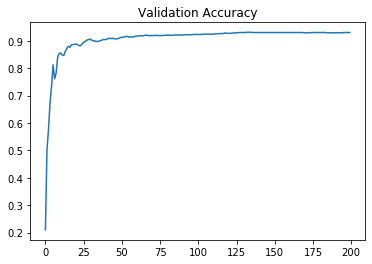

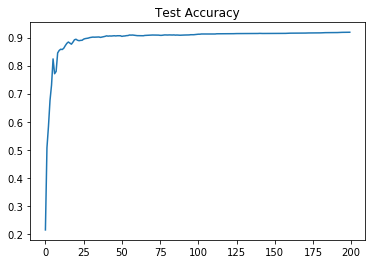

Final Train Accuracy= 0.98
Final Validation Accuracy= 0.93
Final Test Accuracy= 0.92


In [10]:
# YOUR CODE HERE
trainData, validData, testData, trainTarget, validTarget, testTarget = loadData()

trainData = trainData.reshape(trainData.shape[0], -1)
validData = validData.reshape(validData.shape[0], -1)
testData = testData.reshape(testData.shape[0], -1)

hidden_size = 1000
num_classes = 10
input_size = trainData.shape[1]

W1 = np.random.normal(0, np.sqrt(2.0 / (input_size + hidden_size)), (input_size + 1, hidden_size))
W2 = np.random.normal(0, np.sqrt(2.0 / (hidden_size + num_classes)), (hidden_size + 1, num_classes))

PT_W1, OPT_W2, train_loss, train_acc, val_acc, test_acc = train(trainData, trainTarget, W1, W2, 200, 0.9, 1e-5, validData, validTarget, testData, testTarget)

plt.plot(range(200), train_acc)
plt.title('Training Accuracy')
plt.show()

plt.plot(range(200), val_acc)
plt.title('Validation Accuracy')
plt.show()

plt.plot(range(200), test_acc)
plt.title('Test Accuracy')
plt.show()

print('Final Train Accuracy= {}'.format(round(train_acc[-1], 2)))
print('Final Validation Accuracy= {}'.format(round(val_acc[-1], 2)))
print('Final Test Accuracy= {}'.format(round(test_acc[-1], 2)))

## Graphs
<img src="networkTestGraphs.png">

## Results
Final Train Accuracy= 0.98
Final Test Accuracy= 0.92
Final Validation Accuracy= 0.93

## Hyperparameter investigation [3 points]

Continue to use $\alpha=0.9$ and $\eta=10^{-5}$.

Test your network with 500 and 1500 hidden nodes and train for 200 epochs. Comment based on the validation accuracy after how many epochs training could be terminated early. 

Plot the training and validation accuracy curves for all three network sizes (500, 1000, 1500) and 200 training epochs, and report the test accuracy for your selected network size and training length. Show the plots and state the final accuracies in the next text cell.

Iteration 1: train loss = 2.527896809547996, train accuracy = 0.0532
Iteration 1: val accuracy = 0.227
Iteration 2: train loss = 2.190893926828369, train accuracy = 0.2298
Iteration 2: val accuracy = 0.601
Iteration 3: train loss = 1.5244927870125349, train accuracy = 0.5943333333333334
Iteration 3: val accuracy = 0.587
Iteration 4: train loss = 1.2439804612528997, train accuracy = 0.581
Iteration 4: val accuracy = 0.737
Iteration 5: train loss = 0.9082115525117153, train accuracy = 0.7480666666666667
Iteration 5: val accuracy = 0.696
Iteration 6: train loss = 0.9109524750580685, train accuracy = 0.7132
Iteration 6: val accuracy = 0.803
Iteration 7: train loss = 0.7203556449240996, train accuracy = 0.8052
Iteration 7: val accuracy = 0.772
Iteration 8: train loss = 0.8471392679749513, train accuracy = 0.7683333333333333
Iteration 8: val accuracy = 0.84
Iteration 9: train loss = 0.6138768605435796, train accuracy = 0.8352
Iteration 9: val accuracy = 0.841
Iteration 10: train loss = 0.569

Iteration 74: train loss = 0.2378546942533926, train accuracy = 0.9326666666666666
Iteration 74: val accuracy = 0.918
Iteration 75: train loss = 0.2362359639714618, train accuracy = 0.9330666666666667
Iteration 75: val accuracy = 0.919
Iteration 76: train loss = 0.2346389505608347, train accuracy = 0.9331333333333334
Iteration 76: val accuracy = 0.919
Iteration 77: train loss = 0.2330835542528069, train accuracy = 0.9336
Iteration 77: val accuracy = 0.92
Iteration 78: train loss = 0.23155509326350984, train accuracy = 0.9343333333333333
Iteration 78: val accuracy = 0.92
Iteration 79: train loss = 0.23004346954776436, train accuracy = 0.9345333333333333
Iteration 79: val accuracy = 0.92
Iteration 80: train loss = 0.2285425667578594, train accuracy = 0.9348
Iteration 80: val accuracy = 0.922
Iteration 81: train loss = 0.22705010083518404, train accuracy = 0.9352666666666667
Iteration 81: val accuracy = 0.923
Iteration 82: train loss = 0.22556176228390037, train accuracy = 0.9357333333333

Iteration 146: train loss = 0.15157481091707692, train accuracy = 0.9602
Iteration 146: val accuracy = 0.931
Iteration 147: train loss = 0.15064737907667194, train accuracy = 0.9605333333333334
Iteration 147: val accuracy = 0.932
Iteration 148: train loss = 0.14972610778655102, train accuracy = 0.9607333333333333
Iteration 148: val accuracy = 0.933
Iteration 149: train loss = 0.1488105025595049, train accuracy = 0.9613333333333334
Iteration 149: val accuracy = 0.933
Iteration 150: train loss = 0.1479015134662253, train accuracy = 0.9618666666666666
Iteration 150: val accuracy = 0.933
Iteration 151: train loss = 0.14699740464546673, train accuracy = 0.9619333333333333
Iteration 151: val accuracy = 0.933
Iteration 152: train loss = 0.14609851553613915, train accuracy = 0.9622
Iteration 152: val accuracy = 0.933
Iteration 153: train loss = 0.14520395493795743, train accuracy = 0.9624666666666667
Iteration 153: val accuracy = 0.933
Iteration 154: train loss = 0.14431538572978764, train acc

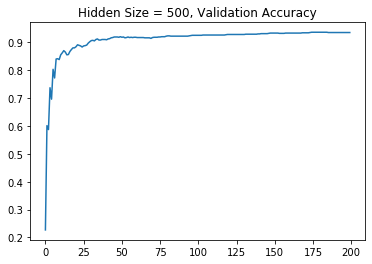

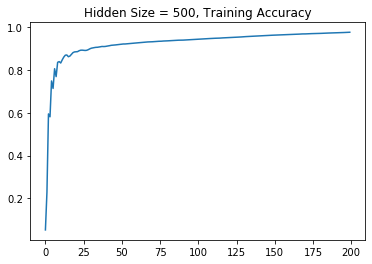

Hidden Size = 500: Final Test Accuracy= 0.92
Iteration 1: train loss = 2.5669137817827163, train accuracy = 0.09626666666666667
Iteration 1: val accuracy = 0.21
Iteration 2: train loss = 2.377739978454189, train accuracy = 0.21093333333333333
Iteration 2: val accuracy = 0.5
Iteration 3: train loss = 2.0151344785119494, train accuracy = 0.5178
Iteration 3: val accuracy = 0.575
Iteration 4: train loss = 1.4896153806117223, train accuracy = 0.5808666666666666
Iteration 4: val accuracy = 0.673
Iteration 5: train loss = 1.0607990172655213, train accuracy = 0.6724666666666667
Iteration 5: val accuracy = 0.733
Iteration 6: train loss = 0.9223224604361152, train accuracy = 0.7132666666666667
Iteration 6: val accuracy = 0.812
Iteration 7: train loss = 0.7015449224874232, train accuracy = 0.8167333333333333
Iteration 7: val accuracy = 0.761
Iteration 8: train loss = 0.7366104277201269, train accuracy = 0.7644
Iteration 8: val accuracy = 0.782
Iteration 9: train loss = 0.6822151453901429, train a

Iteration 73: train loss = 0.23073093502169803, train accuracy = 0.9338
Iteration 73: val accuracy = 0.92
Iteration 74: train loss = 0.22903259115154628, train accuracy = 0.9339333333333333
Iteration 74: val accuracy = 0.919
Iteration 75: train loss = 0.22738357900194117, train accuracy = 0.9337333333333333
Iteration 75: val accuracy = 0.919
Iteration 76: train loss = 0.22574690067198086, train accuracy = 0.9341333333333334
Iteration 76: val accuracy = 0.919
Iteration 77: train loss = 0.22413868614871915, train accuracy = 0.9347333333333333
Iteration 77: val accuracy = 0.919
Iteration 78: train loss = 0.22257131864735807, train accuracy = 0.9352666666666667
Iteration 78: val accuracy = 0.919
Iteration 79: train loss = 0.22099221560763027, train accuracy = 0.936
Iteration 79: val accuracy = 0.92
Iteration 80: train loss = 0.21942246705528226, train accuracy = 0.9366
Iteration 80: val accuracy = 0.92
Iteration 81: train loss = 0.21788462100687403, train accuracy = 0.9369333333333333
Iter

Iteration 144: train loss = 0.1428067279868883, train accuracy = 0.9636
Iteration 144: val accuracy = 0.93
Iteration 145: train loss = 0.14186886625912684, train accuracy = 0.9637333333333333
Iteration 145: val accuracy = 0.93
Iteration 146: train loss = 0.14093672088586, train accuracy = 0.9641333333333333
Iteration 146: val accuracy = 0.93
Iteration 147: train loss = 0.14001189689625698, train accuracy = 0.9645333333333334
Iteration 147: val accuracy = 0.93
Iteration 148: train loss = 0.1390923846673726, train accuracy = 0.9647333333333333
Iteration 148: val accuracy = 0.93
Iteration 149: train loss = 0.13817875610583366, train accuracy = 0.9648666666666667
Iteration 149: val accuracy = 0.93
Iteration 150: train loss = 0.13727244048326878, train accuracy = 0.9649333333333333
Iteration 150: val accuracy = 0.93
Iteration 151: train loss = 0.13637198834150066, train accuracy = 0.9654666666666667
Iteration 151: val accuracy = 0.93
Iteration 152: train loss = 0.13547688559914492, train ac

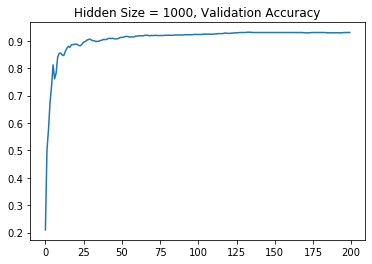

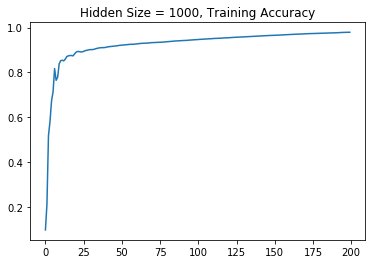

Hidden Size = 1000: Final Test Accuracy= 0.92
Iteration 1: train loss = 2.3177166229655404, train accuracy = 0.1218
Iteration 1: val accuracy = 0.319
Iteration 2: train loss = 1.9190674824764282, train accuracy = 0.3248
Iteration 2: val accuracy = 0.671
Iteration 3: train loss = 1.658303285179064, train accuracy = 0.6540666666666667
Iteration 3: val accuracy = 0.575
Iteration 4: train loss = 1.8153590795228816, train accuracy = 0.5844
Iteration 4: val accuracy = 0.698
Iteration 5: train loss = 1.1391133619957379, train accuracy = 0.6904
Iteration 5: val accuracy = 0.595
Iteration 6: train loss = 1.484924094645344, train accuracy = 0.6122
Iteration 6: val accuracy = 0.748
Iteration 7: train loss = 0.8779156809811467, train accuracy = 0.7505333333333334
Iteration 7: val accuracy = 0.809
Iteration 8: train loss = 0.7013079151211885, train accuracy = 0.8066666666666666
Iteration 8: val accuracy = 0.709
Iteration 9: train loss = 0.9333629645400029, train accuracy = 0.7060666666666666
Iterat

Iteration 73: train loss = 0.22889680612692867, train accuracy = 0.9347333333333333
Iteration 73: val accuracy = 0.919
Iteration 74: train loss = 0.22722751761094462, train accuracy = 0.9354
Iteration 74: val accuracy = 0.919
Iteration 75: train loss = 0.22560479492004434, train accuracy = 0.9358666666666666
Iteration 75: val accuracy = 0.919
Iteration 76: train loss = 0.2239759784685462, train accuracy = 0.9368666666666666
Iteration 76: val accuracy = 0.919
Iteration 77: train loss = 0.22232978675525694, train accuracy = 0.9374666666666667
Iteration 77: val accuracy = 0.919
Iteration 78: train loss = 0.2207036146674729, train accuracy = 0.9379333333333333
Iteration 78: val accuracy = 0.919
Iteration 79: train loss = 0.21912358910241467, train accuracy = 0.9385333333333333
Iteration 79: val accuracy = 0.918
Iteration 80: train loss = 0.21758090857527804, train accuracy = 0.9388
Iteration 80: val accuracy = 0.918
Iteration 81: train loss = 0.21605112479663832, train accuracy = 0.9390666

Iteration 144: train loss = 0.14026157407787365, train accuracy = 0.9642666666666667
Iteration 144: val accuracy = 0.929
Iteration 145: train loss = 0.1393095710766139, train accuracy = 0.9646666666666667
Iteration 145: val accuracy = 0.929
Iteration 146: train loss = 0.138364144727338, train accuracy = 0.9653333333333334
Iteration 146: val accuracy = 0.929
Iteration 147: train loss = 0.13742450717065247, train accuracy = 0.9658666666666667
Iteration 147: val accuracy = 0.929
Iteration 148: train loss = 0.13649095514004722, train accuracy = 0.966
Iteration 148: val accuracy = 0.929
Iteration 149: train loss = 0.13556425905748665, train accuracy = 0.9662666666666667
Iteration 149: val accuracy = 0.928
Iteration 150: train loss = 0.13464402632650074, train accuracy = 0.9666666666666667
Iteration 150: val accuracy = 0.928
Iteration 151: train loss = 0.133729647468144, train accuracy = 0.9668
Iteration 151: val accuracy = 0.928
Iteration 152: train loss = 0.13282145803829792, train accurac

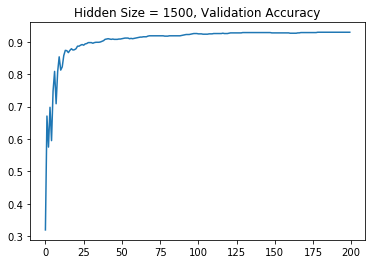

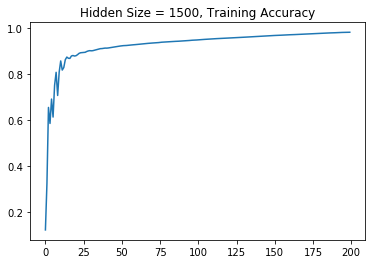

Hidden Size = 1500: Final Test Accuracy= 0.92


In [12]:
# YOUR CODE HERE
for hidden_size in [500, 1000, 1500]:
    trainData, validData, testData, trainTarget, validTarget, testTarget = loadData()

    trainData = trainData.reshape(trainData.shape[0], -1)
    validData = validData.reshape(validData.shape[0], -1)
    testData = testData.reshape(testData.shape[0], -1)

    num_classes = 10
    input_size = trainData.shape[1]

    W1 = np.random.normal(0, np.sqrt(2.0 / (input_size + hidden_size)), (input_size + 1, hidden_size))
    W2 = np.random.normal(0, np.sqrt(2.0 / (hidden_size + num_classes)), (hidden_size + 1, num_classes))

    iterations = 200
    
    OPT_W1, OPT_W2, train_loss, train_acc, val_acc, test_acc = train(trainData, trainTarget, W1, W2, iterations, 0.9, 1e-5, validData, validTarget, testData, testTarget)
    plt.plot(range(iterations), val_acc)
    plt.title('Hidden Size = {}, Validation Accuracy'.format(hidden_size))
    plt.show()
    
    plt.plot(range(iterations), train_acc)
    plt.title('Hidden Size = {}, Training Accuracy'.format(hidden_size))
    plt.show()
    
    print('Hidden Size = {}: Final Test Accuracy= {}'.format(hidden_size, round(test_acc[-1], 2)))

Early stopping the training of a neural network early can prevent overfitting and improve the generalization. The number of ephocs after we could terminate the training could be determined by looking at the validation accuracy. When validation accuracy starts to decrease/or loss starts to increase, the training process can be stopped. For example, for the 500 hidden size, we can see the validation accuracy oscillating at around 93.6% at iteration number 175,and then dropping to 93.5% Therefore we can stop the training there. This could be more clear with an even bigger number of iteration
## Graphs and Results
<img src="500.png">
Hidden Size = 500: Final Test Accuracy = 0.92

<img src="1000.png">
Hidden Size = 1000: Final Test Accuracy = 0.92

<img src="1500.png">
Hidden Size = 1500: Final Test Accuracy = 0.92

